In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
import seaborn as sns
import pandas as pd

def auc_CI(model_name, y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    original_auc = auc(fpr, tpr)

    # Bootstrapping
    n_bootstraps = 1000
    bootstrapped_aucs = []
    np.random.seed(233)
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(0, len(y_scores), len(y_scores))
        fpr_boot, tpr_boot, _ = roc_curve(y_true[indices], y_scores[indices])
        roc_auc_boot = auc(fpr_boot, tpr_boot)
        bootstrapped_aucs.append(roc_auc_boot)
    lower_bound, upper_bound = np.percentile(bootstrapped_aucs, [2.5, 97.5])
    # print("{} —— Confidence interval for the AUC score: [{:0.3f} - {:0.3f}]".format(
    # model_name, lower_bound, upper_bound))
    
    return lower_bound, upper_bound

def roc_curve_CI_band(model_name, y_true, y_scores):
    # Calculate the initial AUROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
#     print(thresholds)
    original_auc = auc(fpr, tpr)

    # Bootstrapping
    n_bootstraps = 1000
    bootstrapped_aucs = []
    indices_log = []
    np.random.seed(233)
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement on the prediction indices
        indices = np.random.randint(0, len(y_scores), len(y_scores))
        fpr_boot, tpr_boot, _ = roc_curve(y_true[indices], y_scores[indices])
        roc_auc_boot = auc(fpr_boot, tpr_boot)
        bootstrapped_aucs.append(roc_auc_boot)
        indices_log.append(indices)
    sorted_scores = np.argsort(bootstrapped_aucs)

    # Computing the lower and upper bound of the 95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("{} —— Confidence interval for the AUC score: [{:0.3f} - {:0.3}]".format(model_name,
        bootstrapped_aucs[confidence_lower], bootstrapped_aucs[confidence_upper]))
    # # Calculate confidence interval
    # lower_bound, upper_bound = np.percentile(bootstrapped_aucs, [2.5, 97.5])
    # print(lower_bound, upper_bound)

    tprs_lower = []
    fprs_lower = []
    tprs_upper = []
    fprs_upper = []
    # Calculate and plot ROC curve for each threshold
    for i, threshold in enumerate(thresholds):
        # Convert predicted probabilities to binary predictions using the current threshold
        y_pred = np.where(y_scores >= threshold, 1, 0)
        # Calculate true positive rate (tpr) and false positive rate (fpr)
        fpr_lower, tpr_lower, _ = roc_curve(y_true[indices_log[confidence_lower]], y_pred[indices_log[confidence_lower]])
        fpr_upper, tpr_upper, _ = roc_curve(y_true[indices_log[confidence_upper]], y_pred[indices_log[confidence_upper]])
#         print(fpr_lower[1], tpr_lower[1], fpr_upper[1], tpr_upper[1])
        # Append tpr and fpr to the lists
        if tpr_lower[1] >= 1 and len(tprs_lower) < 3:
            tprs_lower.append(0)
            fprs_lower.append(0)
            tprs_upper.append(0)
            fprs_upper.append(0)
        else:
            if tpr_lower[1] > tpr[i]:
                tprs_lower.append(tpr[i])
            else:
                tprs_lower.append(tpr_lower[1])
            if tpr_upper[1] < tpr[i]:
                tprs_upper.append(tpr[i])
            else:
                tprs_upper.append(tpr_upper[1]) 
        
        
    return fpr, tpr, original_auc, tprs_lower, tprs_upper



KAD —— Confidence interval for the AUC score: [0.759 - 0.792]
ELIXR —— Confidence interval for the AUC score: [0.810 - 0.837]
Ark+ —— Confidence interval for the AUC score: [0.958 - 0.973]


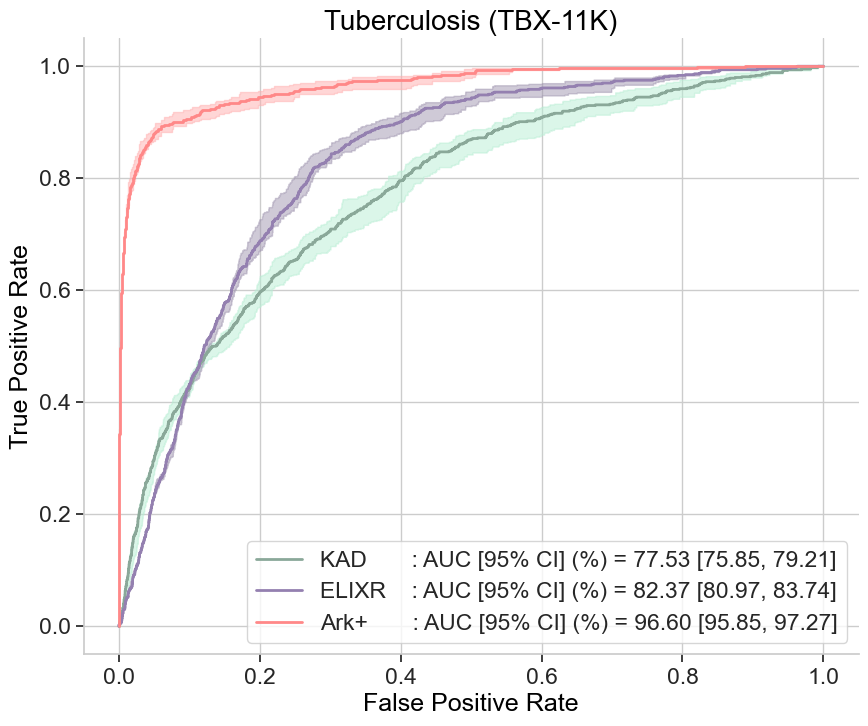

In [8]:
model_name = "Ark+"
df = pd.read_csv("zeroshot_pred_csv/Ark6_swinL768_TBX11K_TBvsSickHealth_ZeroShotPred.csv")
model_name4 = "KAD"
df4 = pd.read_csv("zeroshot_pred_csv/KAD_TBX11k.csv")
model_name5 = "ELIXR"
df5 = pd.read_csv("zeroshot_pred_csv/ELIXR_TBX11k.csv")

y_true = np.array(df['TBX-11K'])
y_scores = np.array(df['Tuberculosis'])
y_true4 = np.array(df4['ground_truth'])
y_scores4 = np.array(df4['prediction'])
y_true5 = np.array(df5['ground_truth'])
y_scores5 = np.array(df5['prediction'])

# Plot ROC curve
plt.figure(figsize=(10, 8))
# sns.set(style='whitegrid', font_scale=1.2)
sns.set_theme(style="whitegrid" , font_scale=1.5, 
              rc={'xtick.bottom': True,
                    'ytick.left': True,
                    'font.sans-serif':'Arial',
                    'pdf.fonttype':42
                    })

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name4, y_true4, y_scores4)
lower_bound, upper_bound = auc_CI(model_name4, y_true4, y_scores4)
plt.plot(fpr, tpr, color='#8aa899', lw=2, label='{:9} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("KAD", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#b8eed4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name5, y_true5, y_scores5)
lower_bound, upper_bound = auc_CI(model_name5, y_true5, y_scores5)
plt.plot(fpr, tpr, color='#9480b0', lw=2, label='{:8} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("ELIXR", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#a096b0', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name, y_true, y_scores)
lower_bound, upper_bound = auc_CI(model_name, y_true, y_scores)
plt.plot(fpr, tpr, color='#ff8888', lw=2, label='{:10} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("Ark+", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#ffafaf', alpha=0.5)


plt.xlabel('False Positive Rate', fontsize=18, color='black' )
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('Tuberculosis (TBX-11K)', fontsize=20, color='black')
sns.despine(left=False, right=True)
plt.legend(loc='lower right')
plt.savefig("zeroshot_tbx11k.png",dpi=500)
plt.show()

XRV-DenseNet —— Confidence interval for the AUC score: [0.764 - 0.781]
XRV-ResNet —— Confidence interval for the AUC score: [0.911 - 0.922]
KAD —— Confidence interval for the AUC score: [0.870 - 0.883]
ELIXR —— Confidence interval for the AUC score: [0.830 - 0.846]
Ark+ —— Confidence interval for the AUC score: [0.954 - 0.962]


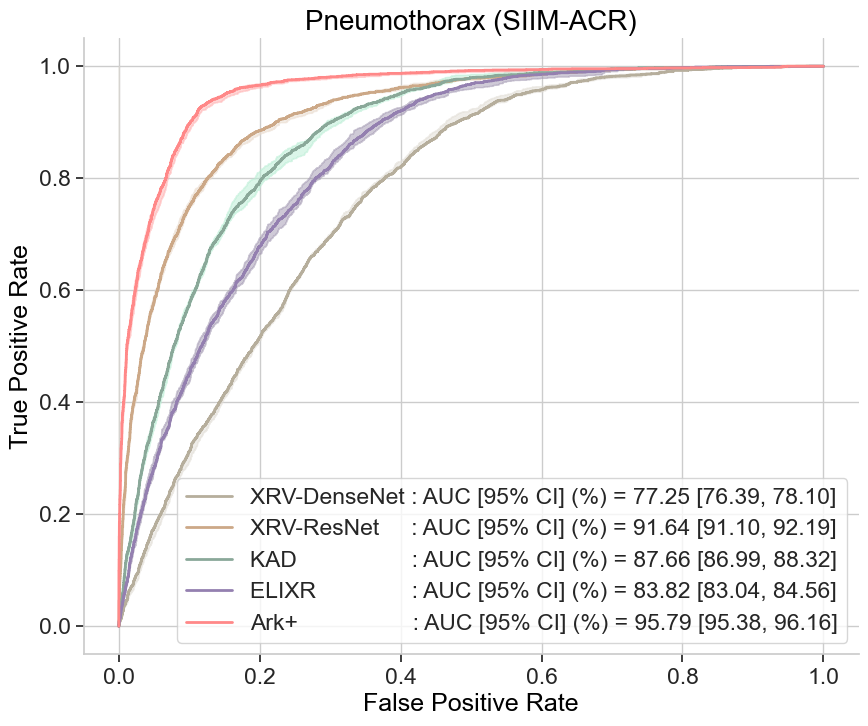

In [9]:
model_name = "Ark+"
df = pd.read_csv("zeroshot_pred_csv/Ark6_swinL768_SIIM_Pneumothorax_ZeroShotPred.csv")
model_name2 = "XRV-ResNet"
df2 = pd.read_csv("zeroshot_pred_csv/ResNet50_512all_SIIM_Pneumothorax_ZeroShotPred.csv")
model_name3 = "XRV-DenseNet"
df3 = pd.read_csv("zeroshot_pred_csv/DenseNet_224all_SIIM_Pneumothorax_ZeroShotPred.csv")
model_name4 = "KAD"
df4 = pd.read_csv("zeroshot_pred_csv/KAD_siim_acr.csv")
model_name5 = "ELIXR"
df5 = pd.read_csv("zeroshot_pred_csv/ELIXR_siim_acr.csv")

y_true = np.array(df['SIIMPTX'])
y_scores = np.array(df['Pneumothorax.1'])
y_true2 = np.array(df2['SIIMPTX'])
y_scores2 = np.array(df2['Pneumothorax'])
y_true3 = np.array(df3['SIIMPTX'])
y_scores3 = np.array(df3['Pneumothorax'])
y_true4 = np.array(df4['ground_truth'])
y_scores4 = np.array(df4['prediction'])
y_true5 = np.array(df5['ground_truth'])
y_scores5 = np.array(df5['prediction'])

# Plot ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid" , font_scale=1.5, 
              rc={'xtick.bottom': True,
                    'ytick.left': True,
                    'font.sans-serif':'Arial',
                    'pdf.fonttype':42
                    })

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name3, y_true3, y_scores3)
lower_bound, upper_bound = auc_CI(model_name3, y_true3, y_scores3)
plt.plot(fpr, tpr, color='#b6ae9c', lw=2, label='{:10} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-DenseNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e0dcd4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name2, y_true2, y_scores2)
lower_bound, upper_bound = auc_CI(model_name2, y_true2, y_scores2)
plt.plot(fpr, tpr, color='#cca887', lw=2, label='{:14} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-ResNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e9dacc', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name4, y_true4, y_scores4)
lower_bound, upper_bound = auc_CI(model_name4, y_true4, y_scores4)
plt.plot(fpr, tpr, color='#8aa899', lw=2, label='{:20} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("KAD", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#b8eed4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name5, y_true5, y_scores5)
lower_bound, upper_bound = auc_CI(model_name5, y_true5, y_scores5)
plt.plot(fpr, tpr, color='#9480b0', lw=2, label='{:19} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("ELIXR", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#a096b0', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name, y_true, y_scores)
lower_bound, upper_bound = auc_CI(model_name, y_true, y_scores)
plt.plot(fpr, tpr, color='#ff8888', lw=2, label='{:21} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("Ark+", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#ffafaf', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=18, color='black' )
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('Pneumothorax (SIIM-ACR)', fontsize=20, color='black')
sns.despine(left=False, right=True)
plt.legend(loc='lower right')
plt.savefig("zeroshot_siim.png",dpi=500)
plt.show()

XRV-DenseNet —— Confidence interval for the AUC score: [0.611 - 0.641]
XRV-ResNet —— Confidence interval for the AUC score: [0.499 - 0.53]
KAD —— Confidence interval for the AUC score: [0.921 - 0.935]
ELIXR —— Confidence interval for the AUC score: [0.941 - 0.952]
Ark+ —— Confidence interval for the AUC score: [0.973 - 0.979]


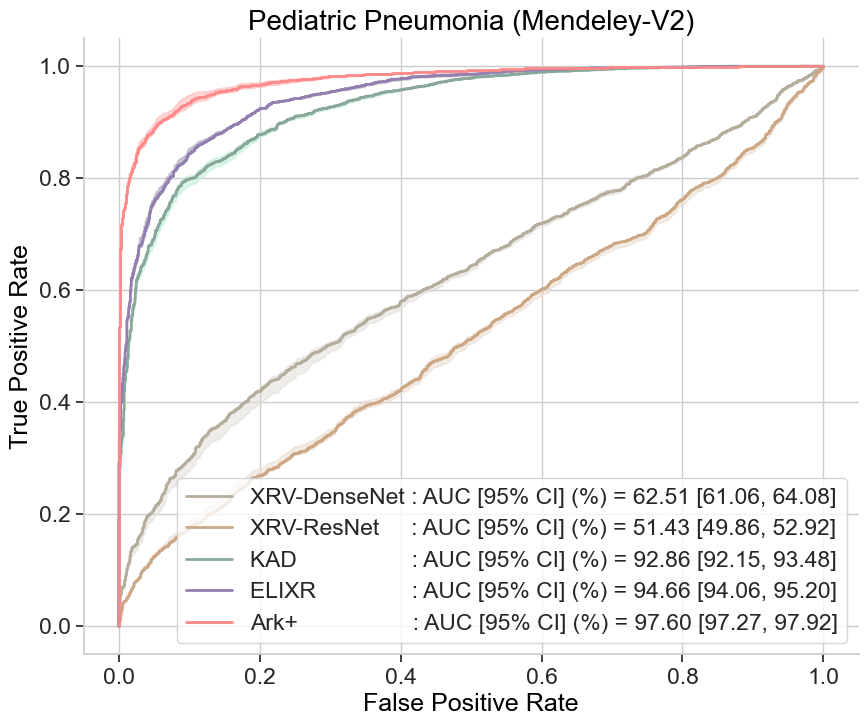

In [10]:
model_name = "Ark+"
df = pd.read_csv("zeroshot_pred_csv/Ark6_SwinLarge768_MendeleyV2all_PNA_ZeroShotPred.csv")
model_name2 = "XRV-ResNet"
df2 = pd.read_csv("zeroshot_pred_csv/ResNet50_512_MendeleyV2all_PNA_ZeroShotPred.csv")
model_name3 = "XRV-DenseNet"
df3 = pd.read_csv("zeroshot_pred_csv/DenseNet_224_MendeleyV2all_PNA_ZeroShotPred.csv")
model_name4 = "KAD"
df4 = pd.read_csv("zeroshot_pred_csv/KAD_mendeleyv2.csv")
model_name5 = "ELIXR"
df5 = pd.read_csv("zeroshot_pred_csv/ELIXR_mendeleyv2.csv")

y_true = np.array(df['MendeleyV2'])
y_scores = np.array(df['Pneumonia.3'])
y_true2 = np.array(df2['MendeleyV2'])
y_scores2 = np.array(df2['Pneumonia'])
y_true3 = np.array(df3['MendeleyV2'])
y_scores3 = np.array(df3['Pneumonia'])
y_true4 = np.array(df4['ground_truth'])
y_scores4 = np.array(df4['prediction'])
y_true5 = np.array(df5['ground_truth'])
y_scores5 = np.array(df5['prediction'])

# Plot ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid" , font_scale=1.5, 
              rc={'xtick.bottom': True,
                    'ytick.left': True,
                    'font.sans-serif':'Arial',
                    'pdf.fonttype':42
                    })

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name3, y_true3, y_scores3)
lower_bound, upper_bound = auc_CI(model_name3, y_true3, y_scores3)
plt.plot(fpr, tpr, color='#b6ae9c', lw=2, label='{:10} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-DenseNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e0dcd4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name2, y_true2, y_scores2)
lower_bound, upper_bound = auc_CI(model_name2, y_true2, y_scores2)
plt.plot(fpr, tpr, color='#cca887', lw=2, label='{:14} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-ResNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e9dacc', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name4, y_true4, y_scores4)
lower_bound, upper_bound = auc_CI(model_name4, y_true4, y_scores4)
plt.plot(fpr, tpr, color='#8aa899', lw=2, label='{:20} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("KAD", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#b8eed4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name5, y_true5, y_scores5)
lower_bound, upper_bound = auc_CI(model_name5, y_true5, y_scores5)
plt.plot(fpr, tpr, color='#9480b0', lw=2, label='{:19} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("ELIXR", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#a096b0', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name, y_true, y_scores)
lower_bound, upper_bound = auc_CI(model_name, y_true, y_scores)
plt.plot(fpr, tpr, color='#ff8888', lw=2, label='{:21} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("Ark+", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#ffafaf', alpha=0.5)


plt.xlabel('False Positive Rate', fontsize=18, color='black' )
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('Pediatric Pneumonia (Mendeley-V2)', fontsize=20, color='black')
sns.despine(left=False, right=True)
plt.legend(loc='lower right')
plt.savefig("zeroshot_mendeleyv2.png",dpi=500)
plt.show()

XRV-DenseNet —— Confidence interval for the AUC score: [0.514 - 0.565]
XRV-ResNet —— Confidence interval for the AUC score: [0.642 - 0.691]
KAD —— Confidence interval for the AUC score: [0.797 - 0.838]
ELIXR —— Confidence interval for the AUC score: [0.567 - 0.624]
Ark+ —— Confidence interval for the AUC score: [0.877 - 0.907]


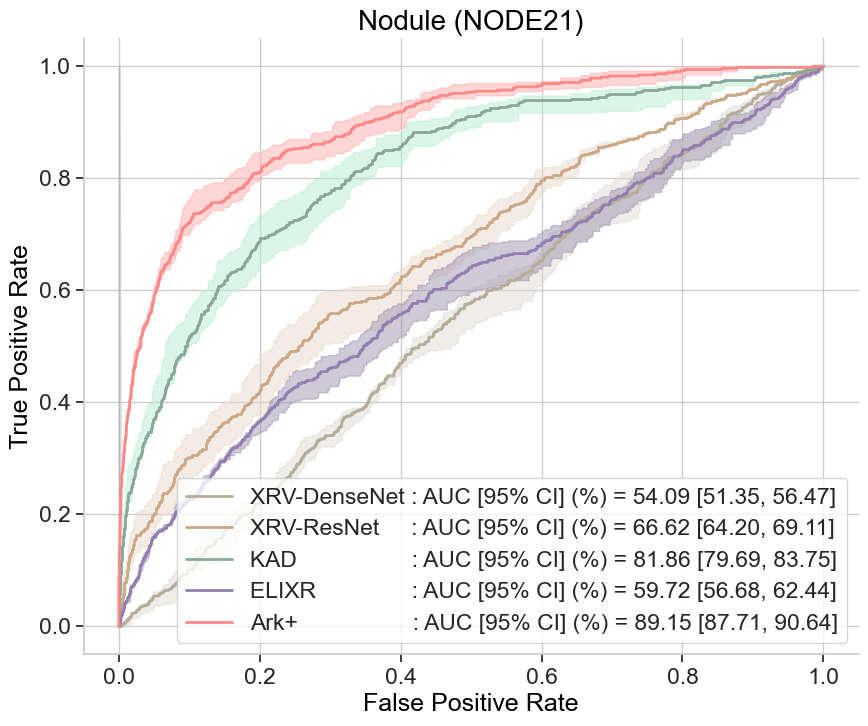

In [11]:
model_name = "Ark+"
df = pd.read_csv("zeroshot_pred_csv/Ark6_SwinL768_Nodule21processed_excludeNIH_ZeroShotPred.csv")
model_name2 = "XRV-ResNet"
df2 = pd.read_csv("zeroshot_pred_csv/ResNet50_512_Nodule21processed_excludeNIH_ZeroShotPred.csv")
model_name3 = "XRV-DenseNet"
df3 = pd.read_csv("zeroshot_pred_csv/DenseNet224all_Nodule21processed_excludeNIH_ZeroShotPred.csv")
model_name4 = "KAD"
df4 = pd.read_csv("zeroshot_pred_csv/KAD_Nodule21processed_excludeNIH_ZeroShotPred.csv")
model_name5 = "ELIXR"
df5 = pd.read_csv("zeroshot_pred_csv/ELIXR_Nodule21processed_excludeNIH_ZeroShotPred.csv")

y_true = np.array(df['Node21'])
y_scores = np.array(df['Nodule'])
y_true2 = np.array(df2['Node21'])
y_scores2 = np.array(df2['Nodule'])
y_true3 = np.array(df3['Node21'])
y_scores3 = np.array(df3['Nodule'])
y_true4 = np.array(df4['ground_truth'])
y_scores4 = np.array(df4['prediction'])
y_true5 = np.array(df5['ground_truth'])
y_scores5 = np.array(df5['prediction'])

# Plot ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid" , font_scale=1.5, 
              rc={'xtick.bottom': True,
                    'ytick.left': True,
                    'font.sans-serif':'Arial',
                    'pdf.fonttype':42
                    })

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name3, y_true3, y_scores3)
lower_bound, upper_bound = auc_CI(model_name3, y_true3, y_scores3)
plt.plot(fpr, tpr, color='#b6ae9c', lw=2, label='{:10} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-DenseNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e0dcd4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name2, y_true2, y_scores2)
lower_bound, upper_bound = auc_CI(model_name2, y_true2, y_scores2)
plt.plot(fpr, tpr, color='#cca887', lw=2, label='{:14} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("XRV-ResNet", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#e9dacc', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name4, y_true4, y_scores4)
lower_bound, upper_bound = auc_CI(model_name4, y_true4, y_scores4)
plt.plot(fpr, tpr, color='#8aa899', lw=2, label='{:20} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("KAD", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#b8eed4', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name5, y_true5, y_scores5)
lower_bound, upper_bound = auc_CI(model_name5, y_true5, y_scores5)
plt.plot(fpr, tpr, color='#9480b0', lw=2, label='{:19} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("ELIXR", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#a096b0', alpha=0.5)

fpr, tpr, original_auc, tprs_lower, tprs_upper = roc_curve_CI_band(model_name, y_true, y_scores)
lower_bound, upper_bound = auc_CI(model_name, y_true, y_scores)
plt.plot(fpr, tpr, color='#ff8888', lw=2, label='{:21} : AUC [95% CI] (%) = {:.2f} [{:.2f}, {:.2f}]'.format("Ark+", original_auc*100,lower_bound*100,upper_bound*100))
# Plot Confidence Interval Band
plt.fill_between(fpr, tprs_lower, tprs_upper, color='#ffafaf', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=18, color='black' )
plt.ylabel('True Positive Rate', fontsize=18, color='black')
plt.title('Nodule (NODE21)', fontsize=20, color='black')
sns.despine(left=False, right=True)
plt.legend(loc='lower right')
plt.savefig("zeroshot_node21.png",dpi=500)
plt.show()
